In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from sklearn.linear_model import LinearRegression
# from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

In [2]:
metadata = pd.read_csv('datasets/top_20_descriptions.csv')
raw_data = pd.read_csv('datasets/top20_raw.csv')
raw_data['InvoiceDate'] = pd.to_datetime(raw_data['InvoiceDate'], format='%Y-%m-%d')

# Visualize the Relation between Price and Demand

/tmp/ipykernel_123394/1307700360.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


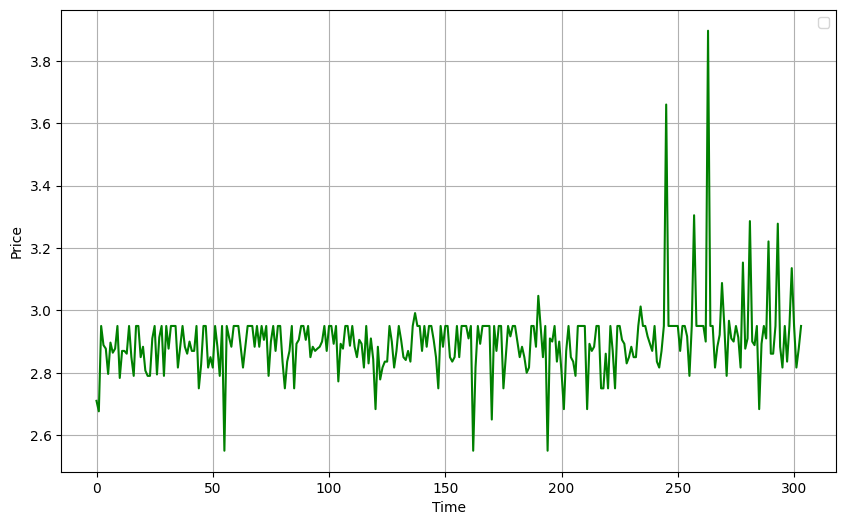

In [31]:

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(raw_data[raw_data['StockCode'] == '85123A']['UnitPrice'].to_numpy(), color='green')
plt.xlabel('Time')
plt.ylabel('Price')
# plt.title('Actual vs Predicted Values')
plt.legend()
plt.grid(True)
plt.show()

/tmp/ipykernel_127832/3952708466.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


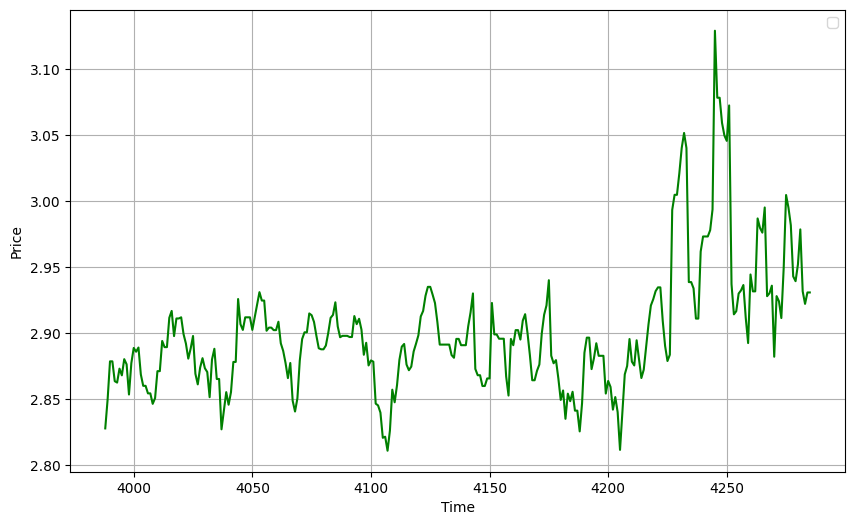

In [24]:
raw_data['UnitPrice_7D'] = raw_data[raw_data['StockCode'] == '85123A']['UnitPrice'].rolling(window=7).mean()
# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(raw_data['UnitPrice_7D'].to_numpy(), color='green')
plt.xlabel('Time')
plt.ylabel('Price')
# plt.title('Actual vs Predicted Values')
plt.legend()
plt.grid(True)
plt.show()

/tmp/ipykernel_123394/3144029345.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


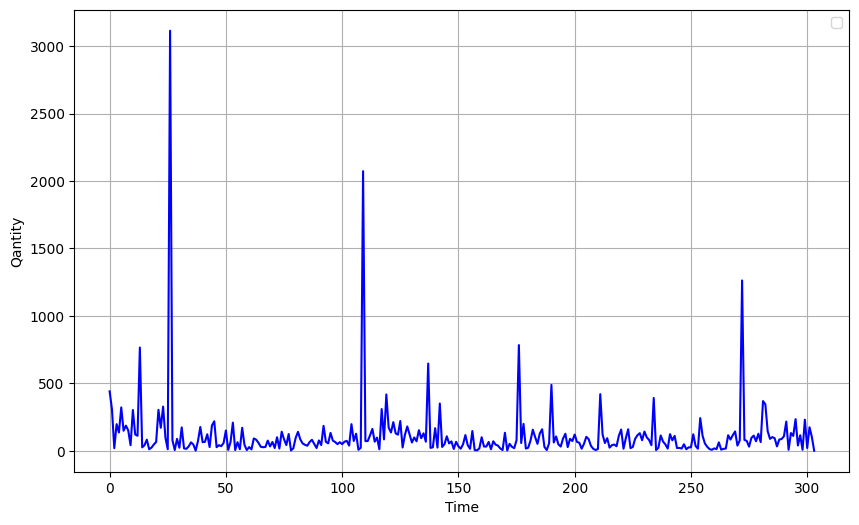

In [32]:

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(raw_data[raw_data['StockCode'] == '85123A']['Quantity'].to_numpy(), color='blue')
plt.xlabel('Time')
plt.ylabel('Qantity')
# plt.title('Actual vs Predicted Values')
plt.legend()
plt.grid(True)
plt.show()

/tmp/ipykernel_127832/3092322998.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


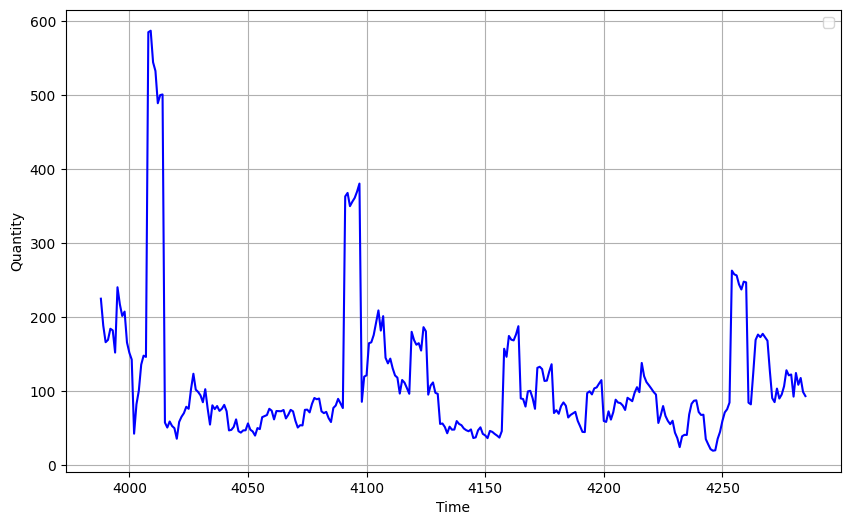

In [25]:
raw_data['Quantity_7D'] = raw_data[raw_data['StockCode'] == '85123A']['Quantity'].rolling(window=7).mean()
# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(raw_data['Quantity_7D'].to_numpy(), color='blue')
plt.xlabel('Time')
plt.ylabel('Quantity')
# plt.title('Actual vs Predicted Values')
plt.legend()
plt.grid(True)
plt.show()

# Regression Model

In [3]:
def LR_model_raw(X_train, X_test, y_train, y_test):
    # Create and train the linear regression model with intercept
    model = LinearRegression(fit_intercept=True)
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Evaluate the model
    # mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    return {
        "intercept": model.intercept_,
        "coefficients": model.coef_,
        "r2": r2
    }

In [4]:
def add_Fourier(data: pd.DataFrame) -> pd.DataFrame:
    data['day_of_year'] = data['InvoiceDate'].dt.dayofyear  # Convert date to day index
    # Define Fourier terms (e.g., yearly seasonality with 3 harmonics)
    num_harmonics = 3
    period = 365  # Assuming daily data

    for k in range(1, num_harmonics + 1):
        data[f'sin_{k}'] = np.sin(2 * np.pi * k * data['day_of_year'] / period)
        data[f'cos_{k}'] = np.cos(2 * np.pi * k * data['day_of_year'] / period)

    data.drop(columns=['day_of_year'], inplace=True)  # Remove intermediate column
    return data

In [5]:
pd.options.mode.chained_assignment = None

In [ ]:
def build_model(model_type):
    if model_type == 'LR':
        train_cols = ['LogUnitPrice']
    elif model_type == 'LR_SW':
        train_cols = ['LogUnitPrice', 'price_ma_3w', 'price_std_3w']
    else:
        train_cols = ['LogUnitPrice', 'price_ma_3w', 'price_std_3w', \
                'sin_1', 'cos_1', 'sin_2', 'cos_2', 'sin_3', 'cos_3']
    results = []
    models = {}
    target_prodcucts = metadata['StockCode'].unique()
    np.random.seed(42)  # Set random seed for reproducibility
    for stock_code in target_prodcucts:
        print(f"Processing stock code: {stock_code}")
        # continue
        data = raw_data[raw_data['StockCode'] == stock_code][['UnitPrice', 'Quantity', 'InvoiceDate']]
        data.reset_index(drop=True, inplace=True)
        # # smooth the unit price and quantity by rolling mean of 7 days
        # data['UnitPrice_14D'] = data['UnitPrice'].rolling(window=14).mean()
        # data['Quantity_14D'] = data['Quantity'].rolling(window=14).mean()
        data['LogUnitPrice'] = np.log(data['UnitPrice'].abs().replace(0, np.nan).dropna()) # Apply UnitPrice, UnitPrice-7D or UnitPrice-14D?
        data['LogQuantity'] = np.log(data['Quantity'].abs().replace(0, np.nan).dropna()) # Apply Quantity, Quantity-7D or Quantity-14D?

        # Define sliding window size (e.g., past 3 weeks)
        window_size = 21  # 3 weeks (assuming daily data)
        # Create rolling window features
        data['price_ma_3w'] = data['UnitPrice'].rolling(window=window_size).mean()
        data['price_std_3w'] = data['UnitPrice'].rolling(window=window_size).std()

        # Create Fourier terms for Seaonality
        data = add_Fourier(data)
        
        # Drop rows with NaN values
        data.dropna(inplace=True)
        if data.shape[0] < 10:
            print("No enough data to train or test the model.")
            continue
        # generate a random sequence with a size of len(data) * 0.8
        random_sequence = np.random.choice(len(data), size=int(len(data) * 0.8), replace=False)
        
        # Split the data into training and testing sets
        train_data = data.iloc[random_sequence]
        test_data = data.drop(data.index[random_sequence])
        # only clip outliers in training data
        train_data['LogUnitPrice'] = train_data['LogUnitPrice'].clip(lower=train_data['LogUnitPrice'].quantile(0.05), upper=train_data['LogUnitPrice'].quantile(0.95))
        train_data['LogQuantity'] = train_data['LogQuantity'].clip(lower=train_data['LogQuantity'].quantile(0.05), upper=train_data['LogQuantity'].quantile(0.95))
        X_train = train_data[train_cols].to_numpy() 
        y_train = train_data['LogQuantity'].to_numpy()
        X_test = test_data[train_cols].to_numpy()
        y_test = test_data['LogQuantity'].to_numpy()
        # Train the model
        result = LR_model_raw(X_train, X_test, y_train, y_test)
        if result:
            results.append(f'({stock_code}) {metadata[metadata['StockCode'] == stock_code]['Description'].values[0]}: {result["r2"]}')
            models[stock_code] = {"intercept": result["intercept"], "coefficients": result["coefficients"]}
    return results, models

## Save Results for Model Comparison

In [7]:
results, _ = build_model('LR')
with open('results/price_only_train_outliers.txt', 'w') as file:
    for result in results:
        file.write(result + '\n')

results, _ = build_model('LR_SW')
with open('results/SW_results_price_only_train_outliers.txt', 'w') as file:
    for result in results:
        file.write(result + '\n')

results, models = build_model('LR_SW_FW')
with open('results/SW_results_season_FW_price_only_train_outliers.txt', 'w') as file:
    for result in results:
        file.write(result + '\n')

Processing stock code: 85123A
Processing stock code: 84879
Processing stock code: 22086
Processing stock code: 22386
Processing stock code: 82484
Processing stock code: 22470
Processing stock code: 85099B
Processing stock code: 79321
Processing stock code: 22197
Processing stock code: 22502
Processing stock code: 22178
Processing stock code: 85099F
Processing stock code: 21137
Processing stock code: 22423
Processing stock code: 47566
Processing stock code: 23166
Processing stock code: 23284
Processing stock code: 23298
Processing stock code: 23203
Processing stock code: 23843
No enough data to train or test the model.
Processing stock code: 85123A
Processing stock code: 84879
Processing stock code: 22086
Processing stock code: 22386
Processing stock code: 82484
Processing stock code: 22470
Processing stock code: 85099B
Processing stock code: 79321
Processing stock code: 22197
Processing stock code: 22502
Processing stock code: 22178
Processing stock code: 85099F
Processing stock code: 

In [ ]:
# Save the models dictionary to a file
with open('best_model.pkl', 'wb') as file:
    pickle.dump(models, file)

In [8]:
from collections import defaultdict
rslt_dict = defaultdict(list)

# Read lines from the text file
with open('results/price_only_train_outliers.txt', 'r') as file:
    lines = file.readlines()

for line in lines:
    rslt = line.replace('\n','').split(' ')
    code = rslt[0]
    value = float(rslt[-1])
    rslt_dict[code].append(value)

# Read lines from the text file
with open('results/SW_results_price_only_train_outliers.txt', 'r') as file:
    lines = file.readlines()
    
# rslt_dict = defaultdict(list)
for line in lines:
    rslt = line.replace('\n','').split(' ')
    code = rslt[0]
    value = float(rslt[-1])
    rslt_dict[code].append(value)

# Read lines from the text file
with open('results/SW_results_season_FW_price_only_train_outliers.txt', 'r') as file:
    lines = file.readlines()
    
# rslt_dict = defaultdict(list)
for line in lines:
    rslt = line.replace('\n','').split(' ')
    code = rslt[0]
    value = float(rslt[-1])
    rslt_dict[code].append(value)

In [9]:
rslt_df = pd.DataFrame.from_dict(rslt_dict, orient='index', columns=['Naive LR', 'LR with Sliding Window', 'LR with Sliding Window and Fourier'])
rslt_df.reset_index(inplace=True)
rslt_df.rename(columns={'index': 'StockCode'}, inplace=True)
rslt_df.head()

,StockCode,Naive LR,LR with Sliding Window,LR with Sliding Window and Fourier
0,(85123A),-0.207395,-0.202387,-0.143169
1,(84879),0.427817,0.443653,0.540687
2,(22086),-0.048625,0.241137,0.197151
3,(22386),-0.031222,0.241694,0.265204
4,(82484),-0.041403,-0.101080,-0.091007


In [10]:
rslt_df.to_csv('model_comparison.csv', index=False)

In [11]:
rslt_df.head()

,StockCode,Naive LR,LR with Sliding Window,LR with Sliding Window and Fourier
0,(85123A),-0.207395,-0.202387,-0.143169
1,(84879),0.427817,0.443653,0.540687
2,(22086),-0.048625,0.241137,0.197151
3,(22386),-0.031222,0.241694,0.265204
4,(82484),-0.041403,-0.101080,-0.091007


# Apply Model to the Next Year

In [13]:
promote_df = pd.read_csv('promote.csv')
promote_df.dropna(inplace=True)
promote_df.rename(columns={'Unnamed: 0': 'StockCode'}, inplace=True)
promote_df.head()


,StockCode,12/1/2011,12/2/2011,12/3/2011,12/5/2011,12/6/2011,12/7/2011,12/8/2011,12/9/2011,12/10/2011,...,3/21/2012,3/22/2012,3/23/2012,3/24/2012,3/26/2012,3/27/2012,3/28/2012,3/29/2012,3/30/2012,3/31/2012
0,85123A,1.61,1.60,1.82,1.84,3.60,1.84,1.86,1.86,1.55,...,161.00,1.87,1.78,1.85,1.77,1.87,1.79,1.86,1.79,1.79
1,84879,0.94,0.86,1.60,0.94,1.63,0.77,0.92,0.89,1.68,...,0.91,0.88,0.92,0.92,0.85,0.94,0.93,0.91,0.75,0.93
2,21212,0.67,0.68,1.88,0.80,0.60,0.84,0.85,0.85,0.78,...,1.84,0.80,0.80,1.80,0.78,0.84,0.84,0.85,0.85,0.83
3,21977,0.64,0.50,1.51,0.68,0.66,1.43,0.69,0.65,0.65,...,0.69,0.68,0.61,0.67,0.63,0.63,0.67,0.61,2.38,0.67
4,85099B,1.25,1.41,3.04,1.40,1.19,1.18,1.39,1.41,3.02,...,2.99,1.46,1.19,1.46,1.40,1.41,1.44,1.40,1.37,1.45


In [26]:
unique_stockcodes = promote_df['StockCode'].unique()
print(unique_stockcodes)

['85123A' '84879' '21212' '21977' '85099B' '22197' '22178' '22616' '17003'
 '84077']


In [14]:
# Melt the dataframe to transform columns into rows#
new_df = promote_df.melt(id_vars=['StockCode'], var_name='InvoiceDate', value_name='UnitPrice')
new_df['InvoiceDate'] = pd.to_datetime(new_df['InvoiceDate'], format='%m/%d/%Y')
new_df.head()

,StockCode,InvoiceDate,UnitPrice
0,85123A,2011-12-01,1.61
1,84879,2011-12-01,0.94
2,21212,2011-12-01,0.67
3,21977,2011-12-01,0.64
4,85099B,2011-12-01,1.25


In [15]:
raw_data = pd.concat([raw_data[['StockCode', 'InvoiceDate', 'UnitPrice', 'Quantity']], new_df], ignore_index=True)
raw_data.head()

,StockCode,InvoiceDate,UnitPrice,Quantity
0,21137,2010-12-01,3.39,540.0
1,21137,2010-12-02,3.57,73.0
2,21137,2010-12-05,3.39,24.0
3,21137,2010-12-06,3.39,504.0
4,21137,2010-12-08,3.75,8.0


In [16]:
with open('best_model.pkl', 'rb') as file:
    loaded_models = pickle.load(file)

In [17]:
results = {}
target_prodcucts = promote_df['StockCode'].unique()
for stock_code in target_prodcucts:
    print(f"Processing stock code: {stock_code}")
    if stock_code not in loaded_models:
        print(f"Model for stock code {stock_code} not found.")
        continue
    model_params = loaded_models[stock_code]
    model = LinearRegression()
    model.intercept_ = model_params['intercept']
    model.coef_ = model_params['coefficients']

    # Prepare the data for prediction
    data = raw_data[(raw_data['StockCode'] == stock_code) & (raw_data['InvoiceDate'] >= pd.to_datetime('2011-12-01'))][['UnitPrice', 'Quantity', 'InvoiceDate']]
    data['UnitPrice_14D'] = data['UnitPrice'].rolling(window=14).mean()
    data.dropna(subset=['UnitPrice_14D'], inplace=True)
    data['LogUnitPrice'] = np.log(data['UnitPrice_14D'].abs().replace(0, np.nan).dropna())

    # Define sliding window size (e.g., past 3 weeks)
    window_size = 21  # 3 weeks (assuming daily data)
    # Create rolling window features
    data['price_ma_3w'] = data['UnitPrice'].rolling(window=window_size).mean()
    data['price_std_3w'] = data['UnitPrice'].rolling(window=window_size).std()
    # Create Fourier terms for Seaonality
    data = add_Fourier(data)

    inputs = data[['LogUnitPrice', 'price_ma_3w', 'price_std_3w', \
                               'sin_1', 'cos_1', 'sin_2', 'cos_2', 'sin_3', 'cos_3']].dropna().to_numpy()
    # Make predictions
    y_pred = model.predict(inputs)
    # reverse log transformation on predicted values
    # y_pred = np.exp(y_pred)
    results[stock_code] = y_pred

    

Processing stock code: 85123A
Processing stock code: 84879
Processing stock code: 21212
Model for stock code 21212 not found.
Processing stock code: 21977
Model for stock code 21977 not found.
Processing stock code: 85099B
Processing stock code: 22197
Processing stock code: 22178
Processing stock code: 22616
Model for stock code 22616 not found.
Processing stock code: 17003
Model for stock code 17003 not found.
Processing stock code: 84077
Model for stock code 84077 not found.


In [18]:
results['84879']

array([49.40242139, 50.68178886, 49.83627712, 46.13736848, 45.11695694,
       39.9451098 , 39.53122228, 34.81096891, 34.79899588, 34.88873001,
       35.27072709, 35.09760312, 35.82058168, 36.14748354, 40.1997595 ,
       39.50485703, 39.7963687 , 43.71710157, 44.54860689, 44.70925332,
       44.9880541 , 44.10319268, 44.2562539 , 44.06606031, 42.99930975,
       39.82845434, 38.98572345, 39.08779144, 39.15110736, 38.83622095,
       38.41788833, 38.42343751, 37.47002181, 37.27452875, 36.94940693,
       37.0902441 , 36.75541169, 37.13894251, 36.84422791, 41.31689299,
       41.18611496, 40.8614679 , 40.93425436, 41.28745102, 41.30565772,
       38.02462784, 37.2850857 , 37.22744805, 37.7544635 , 37.30495332,
       37.52164908, 37.29997858, 37.19080483, 36.98252756, 37.85226899,
       37.80213211, 37.9363073 , 37.57424791, 37.72871354, 41.69908913,
       41.75460915, 41.93190241, 41.24365454, 41.38867138, 41.2104238 ,
       41.48033523, 40.44288157, 40.22992331, 39.37617496, 40.46

In [23]:
target_product = '22178'

/tmp/ipykernel_143620/2333894424.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


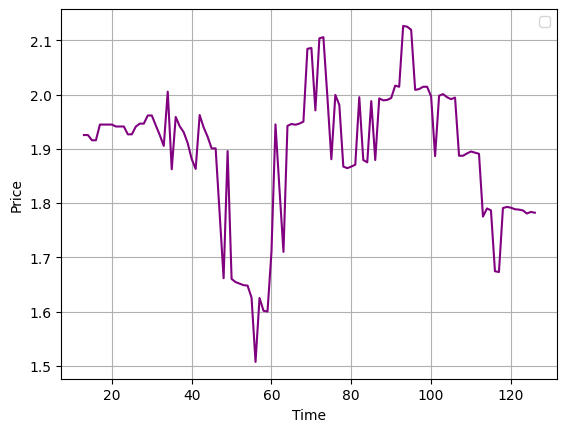

In [24]:
# Plot actual vs predicted values
# plt.figure(figsize=(10, 6))
tmp = raw_data[(raw_data['StockCode'] == target_product) & \
               (raw_data['InvoiceDate'] >= pd.to_datetime('2011-11-01')) & \
                (raw_data['InvoiceDate'] < pd.to_datetime('2012-03-31'))]
tmp['UnitPrice_14D'] = tmp['UnitPrice'].rolling(window=14).mean()

plt.plot(tmp['UnitPrice_14D'].to_numpy(), color='purple')
plt.xlabel('Time')
plt.ylabel('Price')
# plt.title('Actual vs Predicted Values')
plt.legend()
plt.grid(True)
plt.show()

/tmp/ipykernel_143620/3004927285.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


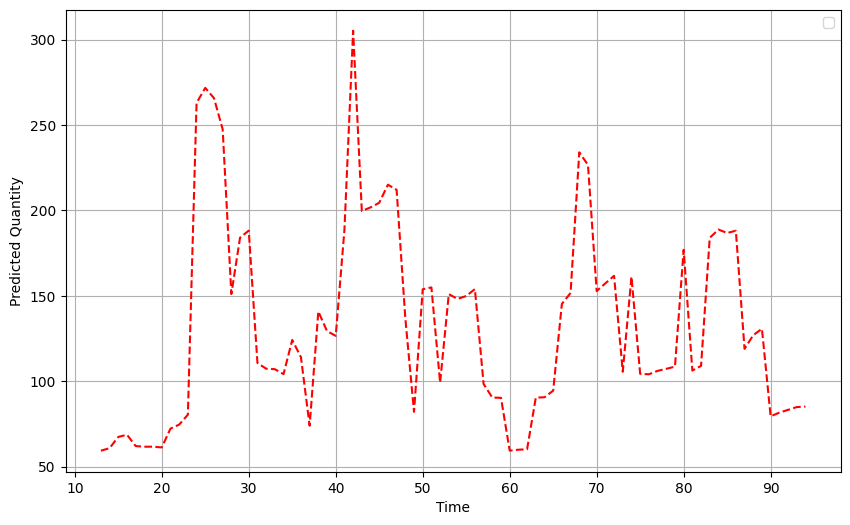

In [25]:
tmp = raw_data[(raw_data['StockCode'] == target_product) & \
               (raw_data['InvoiceDate'] >= pd.to_datetime('2011-11-01')) &\
                (raw_data['InvoiceDate'] < pd.to_datetime('2011-12-01'))]
vis = np.concatenate((tmp['Quantity'].rolling(window=14).mean().to_numpy(), np.exp(results[target_product])))

plt.figure(figsize=(10, 6))
plt.plot(vis, color='red', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Predicted Quantity')
# plt.title('Actual vs Predicted Values')
plt.legend()
plt.grid(True)
plt.show()